In [1]:
from src.blackscholes import *
from src.pinn import *
from src.collocation import *
from src.differential import BlackScholesDifferential
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define hyperparameters
input_dim = 2  # tau and S
hidden_dim = 100
output_dim = 1  # Option price
num_hidden_layers = 4
num_epochs = 20000
learning_rate = 0.001
activation_fn = 'tanh'
S_max = 250
tau_max = 1

# Instantiate model and collocation generator
model = model = PINN(
    input_dim=input_dim, 
    hidden_dim=hidden_dim, 
    output_dim=output_dim, 
    num_hidden_layers=num_hidden_layers, 
    activation_fn=activation_fn,
    lb=(0,0),
    ub=(tau_max,S_max),
    out_scale=S_max
)
params = BlackScholesParams(K=100, r=0.05, sigma=0.2)
option = BlackScholesCall(params)
collocation = CollocationBlackScholes(option, tau_max=tau_max, S_max=S_max, n_collocation=1000, n_boundary=100)
differential = BlackScholesDifferential(option)

optimizer_lbfgs = torch.optim.LBFGS(
    model.parameters(),
    lr=1.0,
    max_iter=50000,
    max_eval=50000,
    history_size=50,
    line_search_fn='strong_wolfe',
    tolerance_change=np.finfo(float).eps,
    tolerance_grad=1e-9
)

# Train the PINN
trained_model = train_pinn(
    model=model,
    collocation=collocation,
    differential=differential,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    gamma = 0.9,
    optimizer_lbfgs = optimizer_lbfgs
)

Epoch 100/20000, PDE Loss: 0.000727, Boundary Loss: 0.329461, Total Loss: 0.330188
Epoch 200/20000, PDE Loss: 0.000125, Boundary Loss: 0.269392, Total Loss: 0.269517
Epoch 300/20000, PDE Loss: 0.000331, Boundary Loss: 0.223183, Total Loss: 0.223514
Epoch 400/20000, PDE Loss: 0.000080, Boundary Loss: 0.187496, Total Loss: 0.187576
Epoch 500/20000, PDE Loss: 0.000089, Boundary Loss: 0.151986, Total Loss: 0.152076
Epoch 600/20000, PDE Loss: 0.000294, Boundary Loss: 0.124377, Total Loss: 0.124671
Epoch 700/20000, PDE Loss: 0.000860, Boundary Loss: 0.103788, Total Loss: 0.104649
Epoch 800/20000, PDE Loss: 0.028737, Boundary Loss: 0.083467, Total Loss: 0.112204
Epoch 900/20000, PDE Loss: 0.001669, Boundary Loss: 0.075666, Total Loss: 0.077334
Epoch 1000/20000, PDE Loss: 0.002345, Boundary Loss: 0.058347, Total Loss: 0.060692
Epoch 1100/20000, PDE Loss: 0.012281, Boundary Loss: 0.049327, Total Loss: 0.061608
Epoch 1200/20000, PDE Loss: 0.001003, Boundary Loss: 0.259657, Total Loss: 0.260660
E

In [3]:
num_points = 100
S_vals = np.linspace(collocation.S_range[0], collocation.S_range[1], num_points)
tau_vals = np.linspace(collocation.tau_range[0], collocation.tau_range[1], num_points)
S_grid, tau_grid = np.meshgrid(S_vals, tau_vals)
grid = np.column_stack([tau_grid.flatten(), S_grid.flatten()])

In [4]:
inputs_tensor = torch.tensor(grid, dtype=torch.float32)

In [5]:
with torch.no_grad():
    pinn_prices = trained_model(inputs_tensor).numpy().reshape(num_points, num_points)
    if trained_model.out_scale:
        pinn_prices *= trained_model.out_scale

In [6]:
bs_prices = calculate_option_price(
        option=option,
        S=grid[:, 1],
        tau=grid[:, 0]
    ).reshape(num_points, num_points)

c:\Users\Yanni\OneDrive\Documenten\Programming\pinn-black-scholes\src\blackscholes.py:29: RuntimeWarning: divide by zero encountered in log
  (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau)),
c:\Users\Yanni\OneDrive\Documenten\Programming\pinn-black-scholes\src\blackscholes.py:29: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / self.K) + (self.r + 0.5 * self.sigma**2) * tau) / (self.sigma * np.sqrt(tau)),


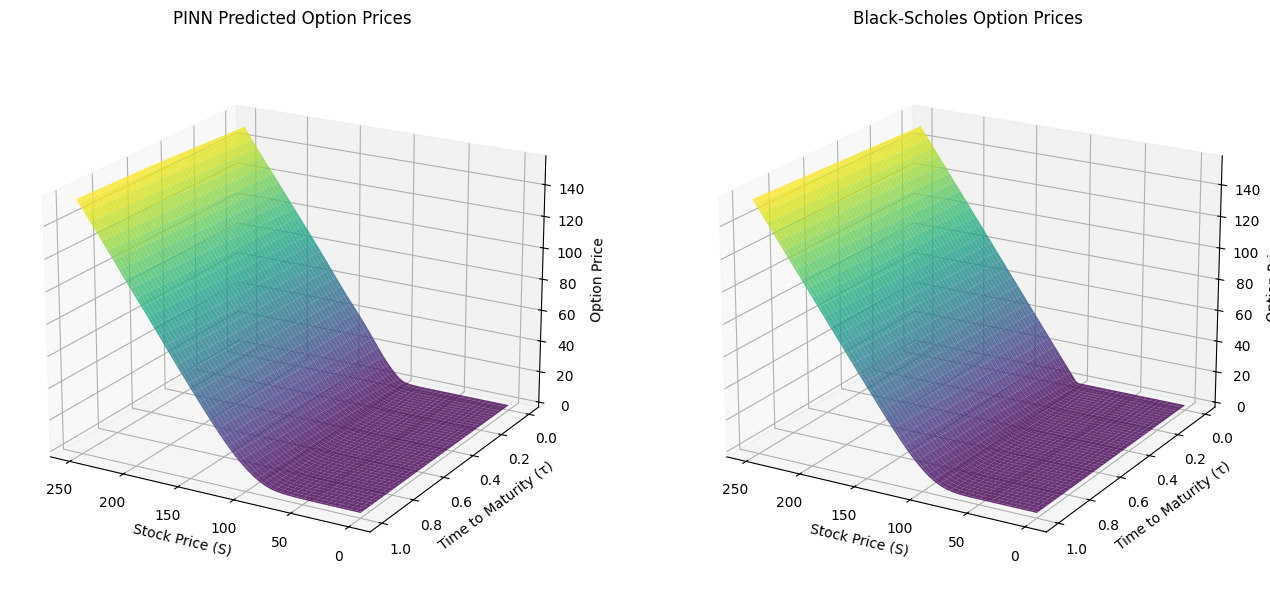

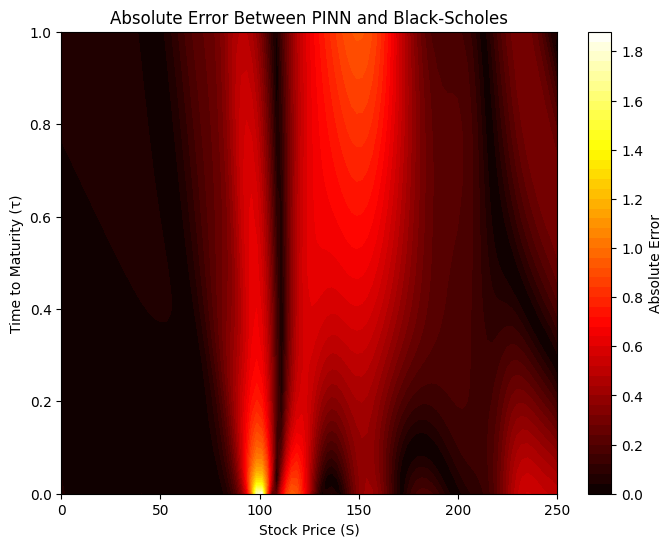

In [7]:
fig = plt.figure(figsize=(16, 8))

# PINN predictions
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(S_grid, tau_grid, pinn_prices, cmap="viridis", alpha=0.8)
ax1.set_title("PINN Predicted Option Prices")
ax1.set_xlabel("Stock Price (S)")
ax1.set_ylabel("Time to Maturity (τ)")
ax1.set_zlabel("Option Price")
ax1.view_init(elev=20, azim=120)

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_grid, tau_grid, bs_prices, cmap="viridis", alpha=0.8)
ax2.set_title("Black-Scholes Option Prices")
ax2.set_xlabel("Stock Price (S)")
ax2.set_ylabel("Time to Maturity (τ)")
ax2.set_zlabel("Option Price")
ax2.view_init(elev=20, azim=120)

plt.show()

absolute_error = np.abs(bs_prices - pinn_prices)

plt.figure(figsize=(8, 6))
plt.contourf(S_grid, tau_grid, absolute_error, levels=50, cmap="hot")
plt.colorbar(label="Absolute Error")
plt.title("Absolute Error Between PINN and Black-Scholes")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time to Maturity (τ)")
plt.show()